# Study beam impact point as a function of beam position


In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import batoid
from scipy import stats
from scipy.spatial.transform import Rotation as transform_rotation


from ghosts import tools
from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom
from ghosts import reflectivity

from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_3, BEAM_CONFIG_4, FAST_BEAM_CONFIG_1, BASE_BEAM_SET
from ghosts.geom_configs import GEOM_CONFIG_0, GEOM_CONFIG_1, GEOM_CONFIG_2

from ghosts.camera import build_camera, show_camera

plt.rcParams['font.size']=12

## Build a telescope

In [3]:
# Second CCOB like geometry, i.e. lenses + filters
#telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_with_filter.yaml")
#telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")
# telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_aligned.yaml")
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_aligned_with_filter.yaml")
#telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_v0.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(telescope, coating='smart',
                                    r_frac=[0.004, 0.04, 0.15])

0

In [4]:
# check the position of L1 apex
l1_entrance = tweak_optics.get_optics_position_z(telescope, "L1_entrance")
focal_plane = tweak_optics.get_optics_position_z(telescope, "Detector")
print(f'L1 entrance z is {l1_entrance:.6f}')
print(f'Focal plane z is {focal_plane:.6f}')
print(f'Distance from L1 entrance to Focal plane is {focal_plane-l1_entrance:.6f}')


L1 entrance z is 3.395712
Focal plane z is 4.427801
Distance from L1 entrance to Focal plane is 1.032089


Direct path is number 28
  central impact point is (0.069835, 0.000065)
  transmission is 0.7647

Maximum expected flux is 0.7647
Maximum bin content is 77.5214


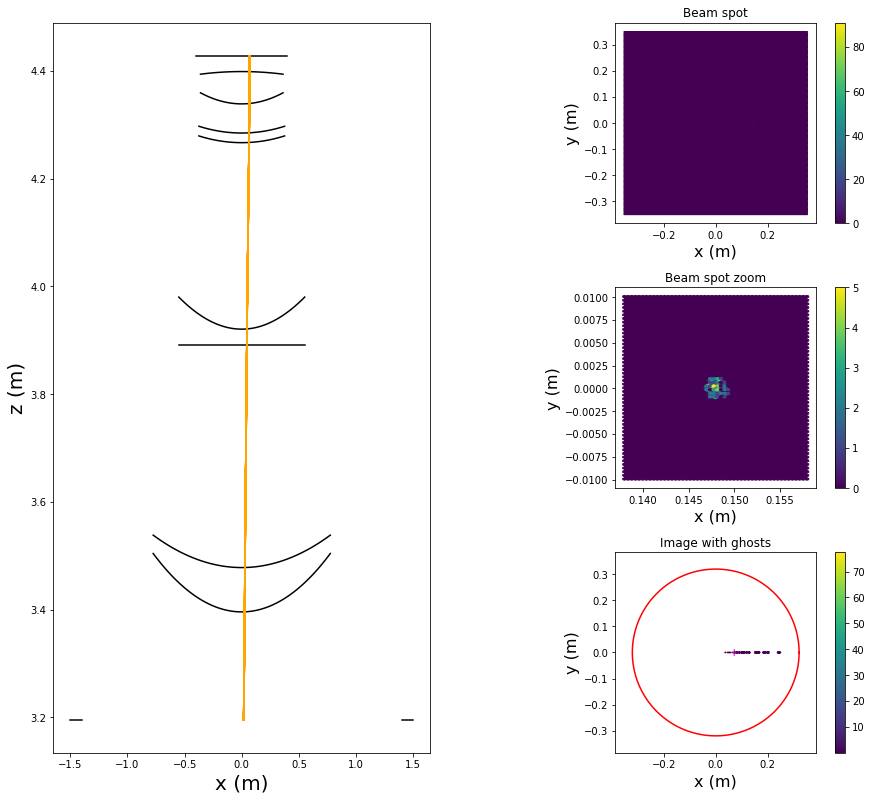

0

In [5]:
# Check that U=0, B rotates the Y axis, B>0 -> +X
center = copy.deepcopy(BEAM_CONFIG_0)
center['n_photons'] = 100

test_beam = beam.rotate_config_to_ub(center, u=0, b=2.5)

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=test_beam)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

   beam_id            wl  n_photons   radius  x_offset  y_offset  z_offset  \
0        0  5.000000e-07       1000  0.00125       0.0         0  2.797473   
1        1  5.000000e-07       1000  0.00125       0.0         0  2.797473   
2        2  5.000000e-07       1000  0.00125       0.0         0  2.797473   
3        3  5.000000e-07       1000  0.00125       0.0         0  2.797473   
4        4  5.000000e-07       1000  0.00125       0.0         0  2.797473   

   z_euler  y_euler  x_euler  
0      0.0      0.0      0.0  
1      0.0      2.5      0.0  
2      0.0      5.0      0.0  
3      0.0      7.5      0.0  
4     30.0      0.0      0.0  


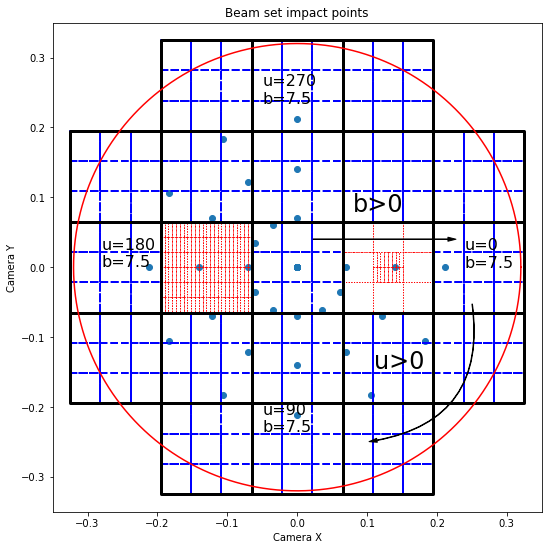

In [6]:
# Check that U=0, B rotates the Y axis, B>0 -> +X, B<0 -> -X
# Check that U>0 rotates around -Z in the right-handed sense
# Check rotation around the clock
beam_set = []
i = 0
for u in range(0, 271, 30):
    for b in np.arange(0, 7.6, 2.5):
        center = copy.deepcopy(BEAM_CONFIG_0)
        beam_conf = beam.rotate_config_to_ub(center, u=u, b=b)
        beam_conf['beam_id'] = i
        beam_set.append(beam_conf)
        i = i + 1

# show beam set content
beam_grid = beam.concat_dicts(beam_set)
print(beam_grid.head())

# simulate
impacts_df = simulator.simulate_impact_points_for_beam_set(telescope, beam_set)

# plot
plotter.plot_impact_points_full_frame(impacts_df)
camera = build_camera()
show_camera(plt.gca(), camera)

# some notes
plt.gca().text(0.24, 0.0, "u=0\nb=7.5", fontsize=16)
plt.gca().text(-0.05, -0.235, "u=90\nb=7.5", fontsize=16)
plt.gca().text(-0.28, 0.001, "u=180\nb=7.5", fontsize=16)
plt.gca().text(-0.05, 0.235, "u=270\nb=7.5", fontsize=16)

# rotation sense
import matplotlib.patches as patches
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
# rotation for b>0
barrow = patches.FancyArrowPatch((0.02, 0.04), (0.23, 0.04), **kw)
plt.gca().text(0.08, 0.08, "b>0", fontsize=24)
plt.gca().add_patch(barrow)
# rotation for u>0
uarrow = patches.FancyArrowPatch((0.25, -0.05), (0.10, -0.25),
                                connectionstyle="arc3,rad=-.5", **kw)
plt.gca().text(0.11, -0.145, "u>0", fontsize=24)
plt.gca().add_patch(uarrow)

## Define functions to read input configuration files in cfg and txt format, and functions to build configurations from configurations

In [7]:
# Read official configs for step 9
def read_ccob_config_cfg(file_path):
    col_names = 'CCOBBPOS CCOBUPOS CCOBXPOS CCOBYPOS darktime expose lambda rebs CCOBBCAM CCOBUCAM CCOBXCAM CCOBYCAM id sens target_phot_per_pix total_phots'.split(' ')
    tg = pd.read_csv(file_path, delim_whitespace=True,
                    header=None, names=col_names, engine="python")    # convert id to int
    tg['id'] = tg['id'].apply(int, base=16)
    # convert string to floats
    f_cols = 'CCOBBPOS CCOBUPOS CCOBXPOS CCOBYPOS darktime expose lambda CCOBBCAM CCOBUCAM CCOBXCAM CCOBYCAM target_phot_per_pix total_phots'.split(' ')
    for col in f_cols:
        tg[col] = tg[col].astype(float)    
    return tg

def build_beam_config_cfg(df, id):
    cc = df[df['id']==id]
    conf_0 = copy.deepcopy(BEAM_CONFIG_0)
    u = cc['CCOBUCAM'].values[0]
    b = cc['CCOBBCAM'].values[0]
    beam_conf = beam.rotate_config_to_ub(conf_0, u, b)
    beam_conf['beam_id'] = cc['id'].values[0]
    beam_conf['wl'] = cc['lambda'].values[0]
    beam_conf['n_photons'] = 1000
    beam_conf['x_offset'] = cc['CCOBXCAM'].values[0]/1000.
    beam_conf['y_offset'] = cc['CCOBYCAM'].values[0]/1000.
    beam_conf['z_offset'] = l1_entrance - 0.200 # 2.797472
    return beam_conf

def read_ccob_config_txt(file_path):
    # define headers
    col_names = 'x y u b lambda sens rebs id expose'.split(' ')
    # ingest
    tg = pd.read_csv(file_path, sep=" ", header=None, names=col_names)
    # strip useless strings    
    for col in col_names:
        tg[col] = tg[col].str.strip(f'{col}=')
    # convert id to int
    tg['id'] = tg['id'].apply(int, base=16)
    # convert string to floats
    f_cols = 'x y u b lambda expose'.split(' ')
    for col in f_cols:
        tg[col] = tg[col].astype(float)    
    return tg

def build_beam_config_txt(df, id):
    cc = df[df['id']==id]
    conf_0 = copy.deepcopy(BEAM_CONFIG_0)
    u = cc['u'].values[0]
    b = cc['b'].values[0]
    beam_conf = beam.rotate_config_to_ub(conf_0, u, b)
    beam_conf['beam_id'] = cc['id'].values[0]
    beam_conf['wl'] = cc['lambda'].values[0]    
    beam_conf['n_photons'] = 1000
    beam_conf['x_offset'] = cc['x'].values[0]/1000.
    beam_conf['y_offset'] = cc['y'].values[0]/1000.
    beam_conf['z_offset'] = l1_entrance - 0.200 # 2.797472
    return beam_conf

def get_ccd(ccd, df):
    return df[(df['sens']==ccd)]

def build_beam_set_cfg(df):
    beam_set = [build_beam_config_cfg(df, id) for id in df['id'].to_list()]
    return beam_set

def build_beam_set_txt(df):
    beam_set = [build_beam_config_txt(df, id) for id in df['id'].to_list()]
    return beam_set


## First read the simplified text version of the configurations file

In [8]:
# First read Andy's text version of step 9 configurations file
tg = read_ccob_config_txt('../data/rband_step9_20221130.txt')
tg.head() 

,x,y,u,b,lambda,sens,rebs,id,expose
0,162.53,204.27,9.8195,-13.5909,542.0,R14_S11,R14/Reb1,5003,0.1
1,162.53,204.27,74.5278,15.7781,542.0,R41_S11,R41/Reb1,5004,0.1
2,162.53,204.27,96.0895,15.3464,542.0,R31_S11,R31/Reb1,312,0.1
3,162.53,204.27,116.1259,16.9071,542.0,R21_S11,R21/Reb1,5006,0.1
4,162.53,204.27,131.1529,19.8851,542.0,R11_S11,R11/Reb1,5007,0.1


In [9]:
# Select a bunch of interesting configuration
r22_s11 = get_ccd('R22_S11', tg)
r11_s11 = get_ccd('R11_S11', tg)
r33_s11 = get_ccd('R33_S11', tg)
r22_s11.head(10)

,x,y,u,b,lambda,sens,rebs,id,expose
51,274.82,288.34,133.6250,18.1894,542.000,R22_S11,R22/Reb1,5054,0.1
78,90.34,421.14,102.1062,19.5603,542.000,R22_S11,R22/Reb1,5081,0.1
106,-239.34,-326.99,126.2036,-18.4832,701.000,R22_S11,R22/Reb1,5109,0.1
118,-149.80,505.67,73.4983,23.5112,701.000,R22_S11,R22/Reb1,5121,0.1
128,-349.58,-123.23,160.5813,-17.0013,701.000,R22_S11,R22/Reb1,5131,0.1
174,-448.17,-18.01,177.6999,-20.3037,659.288,R22_S11,R22/Reb1,5177,0.1
187,-309.96,53.14,9.7285,14.5433,554.615,R22_S11,R22/Reb1,5190,0.1
200,-286.69,-307.44,133.0004,-19.1242,587.004,R22_S11,R22/Reb1,5203,0.1
224,364.46,-167.28,24.6543,-18.3036,610.083,R22_S11,R22/Reb1,5227,0.1
257,-348.63,268.35,37.5857,19.9461,555.812,R22_S11,R22/Reb1,5260,0.1


In [10]:
# Map to a ghosts beam config
r22_s11_beam_set = build_beam_set_txt(r22_s11)
r11_s11_beam_set = build_beam_set_txt(r11_s11)
r33_s11_beam_set = build_beam_set_txt(r33_s11)

In [11]:
r22_s11_beam_set[0]

{'beam_id': 5054,
 'wl': 542.0,
 'n_photons': 1000,
 'radius': 0.00125,
 'x_offset': 0.27482,
 'y_offset': 0.28834,
 'z_offset': 3.195711882,
 'z_euler': 135.0930170603762,
 'y_euler': -12.772939514501296,
 'x_euler': 13.059508444047}

0

/home/bregeon/data/Soft/miniconda3/envs/ghosts/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


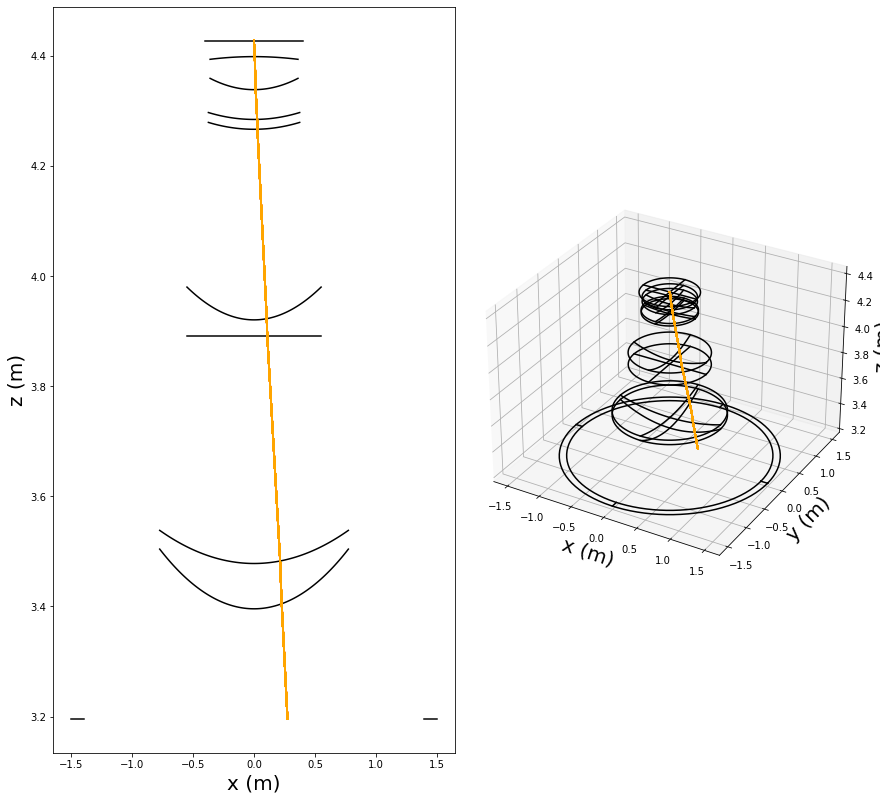

In [12]:
# Run simulation with th e first selected configuration
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=r22_s11_beam_set[0])
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup_3d(telescope, simulation)

In [13]:
impacts_r22_s11 = simulator.simulate_impact_points_for_beam_set(telescope, r22_s11_beam_set)

<AxesSubplot: title={'center': 'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

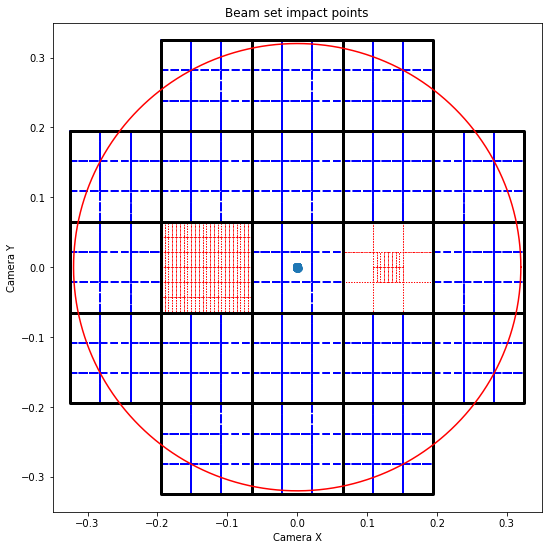

In [14]:
plotter.plot_impact_points_full_frame(impacts_r22_s11)
camera = build_camera()
show_camera(plt.gca(), camera)

In [15]:
impacts_r22_s11

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler,x_spot,y_spot,beam_dist_to_center,spot_dist_to_center,convergence,displacement
5054,5054,542.000,1000,0.00125,0.27482,0.28834,3.195712,135.093017,-12.772940,13.059508,-0.000688,-0.000702,0.398329,0.000983,0.002467,-0.397346
5081,5081,542.000,1000,0.00125,0.09034,0.42114,3.195712,102.823800,-4.261564,19.108192,-0.000266,-0.001218,0.430721,0.001247,0.002895,-0.429474
5109,5109,701.000,1000,0.00125,-0.23934,-0.32699,3.195712,127.660880,11.168734,-14.821948,0.000639,0.000832,0.405224,0.001049,0.002589,-0.404174
5121,5121,701.000,1000,0.00125,-0.14980,0.50567,3.195712,72.096118,7.044430,22.488438,0.000596,-0.002076,0.527392,0.002159,0.004094,-0.525233
5131,5131,701.000,1000,0.00125,-0.34958,-0.12323,3.195712,161.370185,16.085569,-5.578632,0.000815,0.000278,0.370664,0.000861,0.002324,-0.369803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7708,7708,659.511,1000,0.00125,-0.04739,-0.52573,3.195712,95.615187,2.238765,-23.429687,0.000187,0.002101,0.527862,0.002109,0.003996,-0.525752
7718,7718,683.935,1000,0.00125,-0.19926,0.32077,3.195712,56.951148,9.333929,14.633028,0.000433,-0.000750,0.377621,0.000866,0.002292,-0.376756
7726,7726,628.948,1000,0.00125,-0.11512,-0.48754,3.195712,104.332279,5.424827,-21.819739,0.000461,0.001842,0.500947,0.001898,0.003790,-0.499049
7733,7733,646.232,1000,0.00125,0.17679,-0.38423,3.195712,64.020494,-8.296681,-17.413001,-0.000475,0.001055,0.422951,0.001157,0.002736,-0.421794


x_spot is at -17 +/- 1010 mu (dist=4441 mu)
y_spot is at -53 +/- 975 mu (dist=4442 mu)


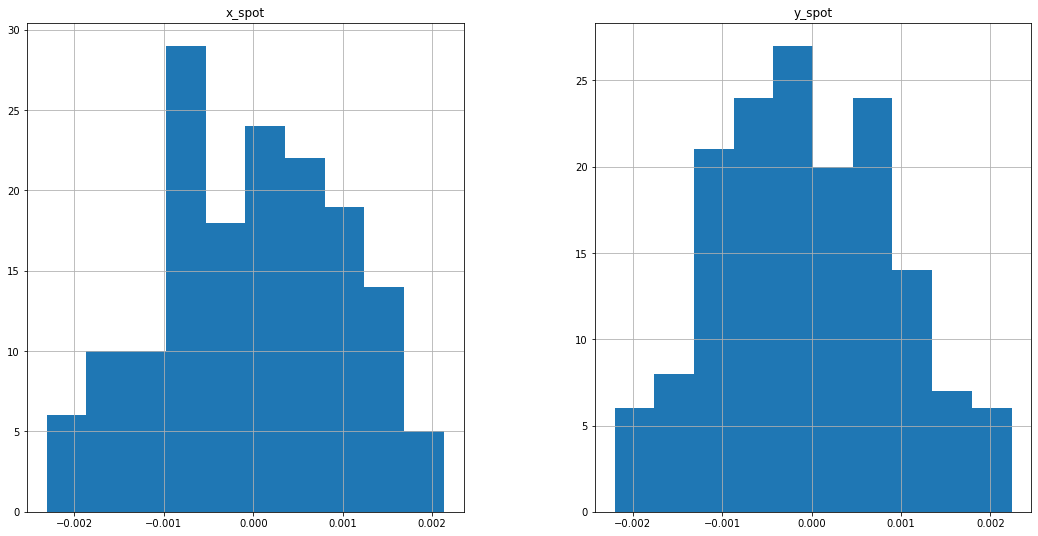

In [16]:
def plot_impact_point_residuals(imp):
    imp.hist(["x_spot", "y_spot"], figsize=(18, 9))
    print(f'x_spot is at {imp["x_spot"].mean()*1e6:.0f} +/- {imp["x_spot"].std()*1e6:.0f} mu (dist={imp["x_spot"].max()*1e6-imp["x_spot"].min()*1e6:.0f} mu)')
    print(f'y_spot is at {imp["y_spot"].mean()*1e6:.0f} +/- {imp["y_spot"].std()*1e6:.0f} mu (dist={imp["y_spot"].max()*1e6-imp["y_spot"].min()*1e6:.0f} mu)')

plot_impact_point_residuals(impacts_r22_s11)

<AxesSubplot: xlabel='wl', ylabel='x_spot'>

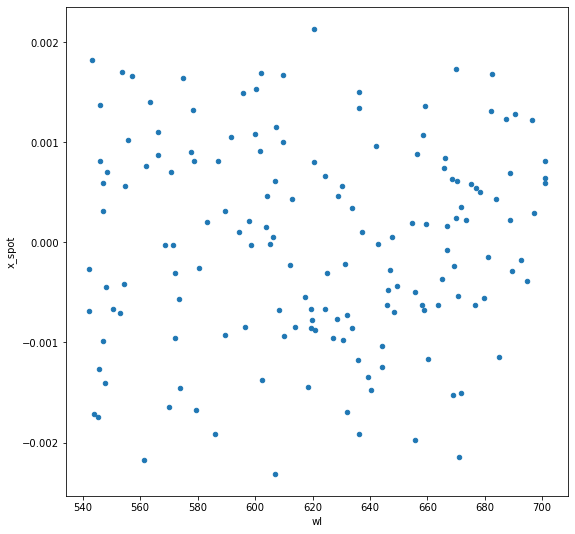

In [17]:
impacts_r22_s11.plot.scatter("wl", "x_spot")

<AxesSubplot: title={'center': 'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

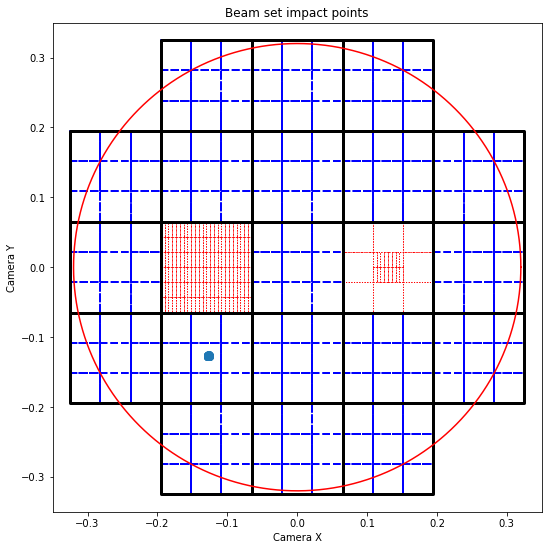

In [18]:
impacts_r11_s11 = simulator.simulate_impact_points_for_beam_set(telescope, r11_s11_beam_set)
plotter.plot_impact_points_full_frame(impacts_r11_s11)
camera = build_camera()
show_camera(plt.gca(), camera)

x_spot is at -126964 +/- 1011 mu (dist=4677 mu)
y_spot is at -126886 +/- 1020 mu (dist=4544 mu)


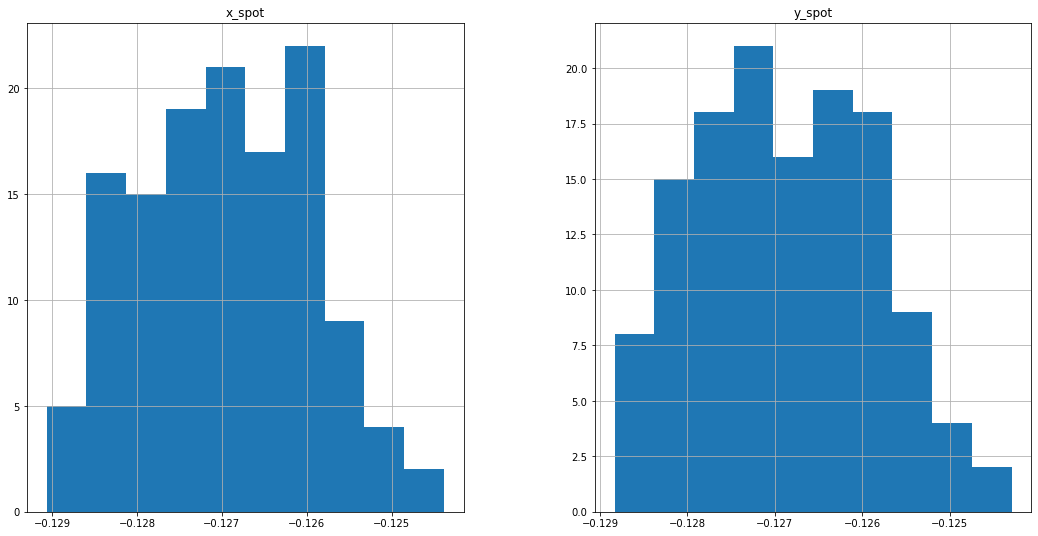

In [19]:
plot_impact_point_residuals(impacts_r11_s11)

<AxesSubplot: title={'center': 'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

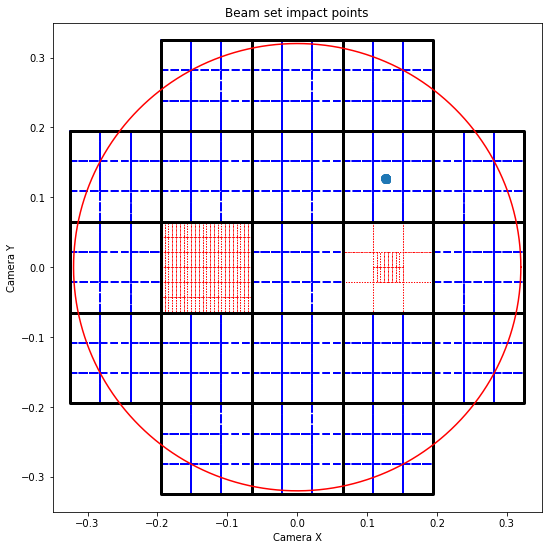

In [20]:
impacts_r33_s11 = simulator.simulate_impact_points_for_beam_set(telescope, r33_s11_beam_set)
plotter.plot_impact_points_full_frame(impacts_r33_s11)
camera = build_camera()
show_camera(plt.gca(), camera)

x_spot is at 127015 +/- 1070 mu (dist=4774 mu)
y_spot is at 126793 +/- 1024 mu (dist=4446 mu)


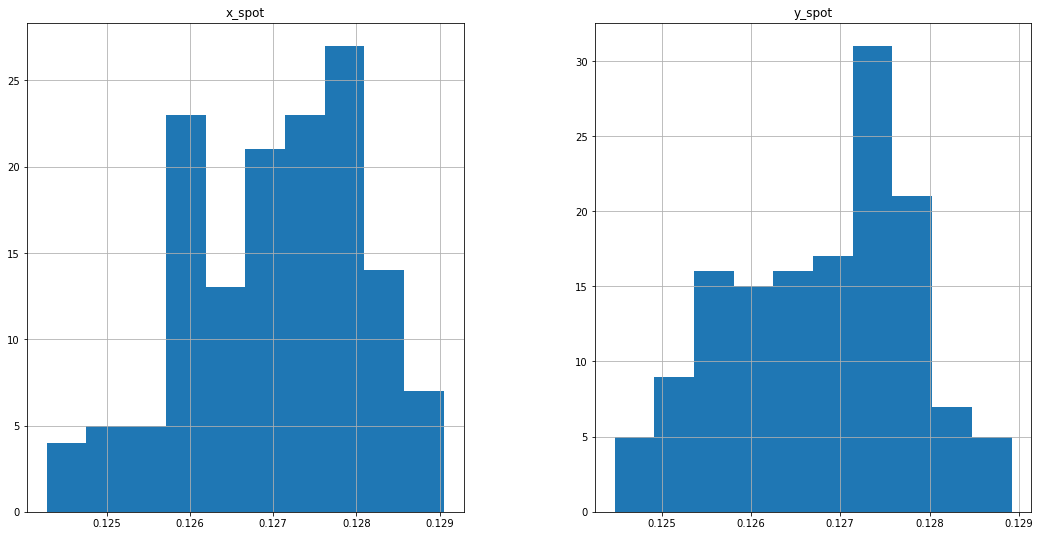

In [21]:
plot_impact_point_residuals(impacts_r33_s11)

## Now read the extracted set of configuration from the official configurations file

In [22]:
df_cfg = read_ccob_config_cfg('../data/rband_step9_20221130_R22_S11.txt')
df_cfg.head()

,CCOBBPOS,CCOBUPOS,CCOBXPOS,CCOBYPOS,darktime,expose,lambda,rebs,CCOBBCAM,CCOBUCAM,CCOBXCAM,CCOBYCAM,id,sens,target_phot_per_pix,total_phots
0,28.1894,134.6250,1448.644,1411.195,10.0,0.3912,542.0,R22/Reb1,18.1894,133.6250,274.82,288.34,9442238,R22_S11,70000.0,3.106700e+09
1,29.5603,103.1062,1253.291,1527.411,10.0,0.3944,542.0,R22/Reb1,19.5603,102.1062,90.34,421.14,9442265,R22_S11,70000.0,3.132200e+09
2,-8.4832,127.2036,990.070,753.394,10.0,0.4870,701.0,R22/Reb1,-18.4832,126.2036,-239.34,-326.99,9442293,R22_S11,70000.0,3.112200e+09
3,33.5112,74.4983,1006.698,1590.690,10.0,0.5037,701.0,R22/Reb1,23.5112,73.4983,-149.80,505.67,9442305,R22_S11,70000.0,3.218900e+09
4,-7.0013,161.5813,862.490,946.771,10.0,0.4829,701.0,R22/Reb1,-17.0013,160.5813,-349.58,-123.23,9442315,R22_S11,70000.0,3.086000e+09


In [23]:
# Select a bunch of interesting configuration
r22_s11_cfg = df_cfg[(df_cfg['sens']=="R22_S11")]
r22_s11_cfg.head(10)

,CCOBBPOS,CCOBUPOS,CCOBXPOS,CCOBYPOS,darktime,expose,lambda,rebs,CCOBBCAM,CCOBUCAM,CCOBXCAM,CCOBYCAM,id,sens,target_phot_per_pix,total_phots
0,28.1894,134.6250,1448.644,1411.195,10.0,0.3912,542.000,R22/Reb1,18.1894,133.6250,274.82,288.34,9442238,R22_S11,70000.0,3.106700e+09
1,29.5603,103.1062,1253.291,1527.411,10.0,0.3944,542.000,R22/Reb1,19.5603,102.1062,90.34,421.14,9442265,R22_S11,70000.0,3.132200e+09
2,-8.4832,127.2036,990.070,753.394,10.0,0.4870,701.000,R22/Reb1,-18.4832,126.2036,-239.34,-326.99,9442293,R22_S11,70000.0,3.112200e+09
3,33.5112,74.4983,1006.698,1590.690,10.0,0.5037,701.000,R22/Reb1,23.5112,73.4983,-149.80,505.67,9442305,R22_S11,70000.0,3.218900e+09
4,-7.0013,161.5813,862.490,946.771,10.0,0.4829,701.000,R22/Reb1,-17.0013,160.5813,-349.58,-123.23,9442315,R22_S11,70000.0,3.086000e+09
5,-10.3037,178.6999,755.105,1042.998,10.0,0.7921,659.288,R22/Reb1,-20.3037,177.6999,-448.17,-18.01,9442361,R22_S11,70000.0,3.147100e+09
6,24.5433,10.7285,886.588,1125.923,10.0,0.4179,554.615,R22/Reb1,14.5433,9.7285,-309.96,53.14,9442374,R22_S11,70000.0,3.048900e+09
7,-9.1242,134.0004,941.196,768.743,10.0,0.5043,587.004,R22/Reb1,-19.1242,133.0004,-286.69,-307.44,9442387,R22_S11,70000.0,3.123600e+09
8,-8.3036,25.6543,1577.653,965.121,10.0,0.5828,610.083,R22/Reb1,-18.3036,24.6543,364.46,-167.28,9442411,R22_S11,70000.0,3.108700e+09
9,29.9461,38.5857,829.308,1336.944,10.0,0.4331,555.812,R22/Reb1,19.9461,37.5857,-348.63,268.35,9442444,R22_S11,70000.0,3.139700e+09


In [24]:
# Map to a ghosts beam config
r22_s11_beam_set_cfg = build_beam_set_cfg(r22_s11_cfg)

In [25]:
r22_s11_beam_set_cfg[0]

{'beam_id': 9442238,
 'wl': 542.0,
 'n_photons': 1000,
 'radius': 0.00125,
 'x_offset': 0.27482,
 'y_offset': 0.28834,
 'z_offset': 3.195711882,
 'z_euler': 135.0930170603762,
 'y_euler': -12.772939514501296,
 'x_euler': 13.059508444047}

0

/home/bregeon/data/Soft/miniconda3/envs/ghosts/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


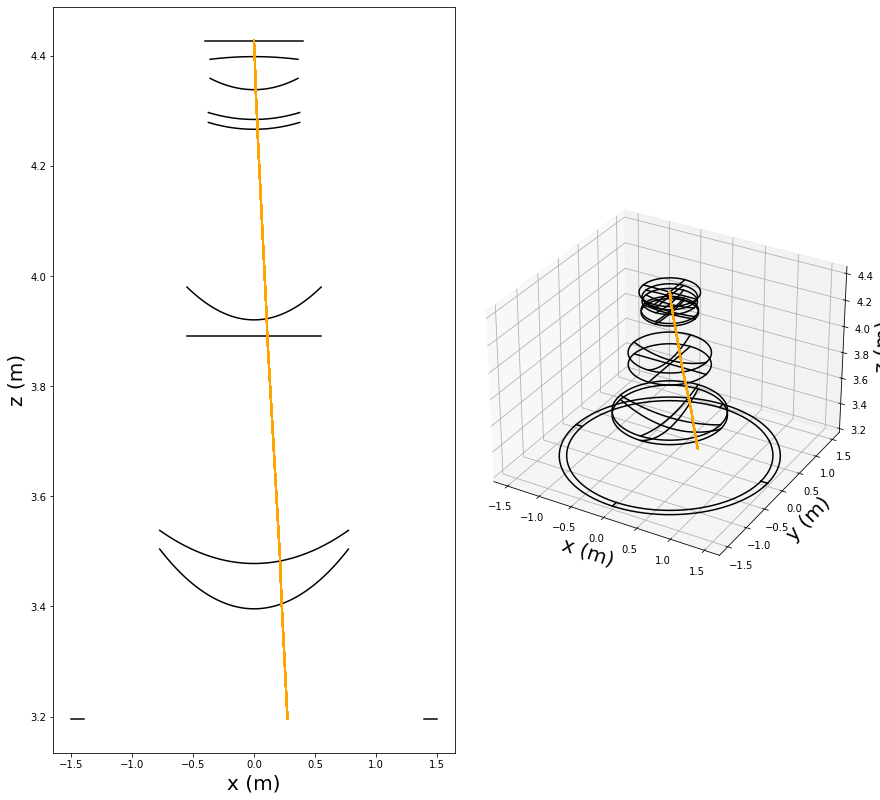

In [26]:
# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=r22_s11_beam_set_cfg[0])
#trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=test_conf)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup_3d(telescope, simulation)

In [27]:
impacts_r22_s11_cfg = simulator.simulate_impact_points_for_beam_set(telescope, r22_s11_beam_set_cfg)

In [28]:
impacts_r22_s11_cfg.head(20)

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler,x_spot,y_spot,beam_dist_to_center,spot_dist_to_center,convergence,displacement
9442238,9442238,542.000,1000,0.00125,0.27482,0.28834,3.195712,135.093017,-12.772940,13.059508,-0.000721,-0.000697,0.398329,0.001003,0.002519,-0.397326
9442265,9442265,542.000,1000,0.00125,0.09034,0.42114,3.195712,102.823800,-4.261564,19.108192,-0.000196,-0.001208,0.430721,0.001224,0.002842,-0.429497
9442293,9442293,701.000,1000,0.00125,-0.23934,-0.32699,3.195712,127.660880,11.168734,-14.821948,0.000610,0.000842,0.405224,0.001040,0.002567,-0.404183
9442305,9442305,701.000,1000,0.00125,-0.14980,0.50567,3.195712,72.096118,7.044430,22.488438,0.000603,-0.002056,0.527392,0.002142,0.004062,-0.525250
9442315,9442315,701.000,1000,0.00125,-0.34958,-0.12323,3.195712,161.370185,16.085569,-5.578632,0.000831,0.000268,0.370664,0.000873,0.002354,-0.369791
9442361,9442361,659.288,1000,0.00125,-0.44817,-0.01801,3.195712,177.842674,20.288676,-0.797937,0.001400,0.000062,0.448532,0.001402,0.003125,-0.447130
9442374,9442374,554.615,1000,0.00125,-0.30996,0.05314,3.195712,9.422461,14.342848,2.431948,0.000571,-0.000119,0.314482,0.000583,0.001855,-0.313899
9442387,9442387,587.004,1000,0.00125,-0.28669,-0.30744,3.195712,134.625148,13.305293,-13.863071,0.000780,0.000840,0.420369,0.001146,0.002726,-0.419223
9442411,9442411,610.083,1000,0.00125,0.36446,-0.16728,3.195712,23.545681,-16.732556,-7.527638,-0.000940,0.000414,0.401016,0.001027,0.002561,-0.399989
9442444,9442444,555.812,1000,0.00125,-0.34863,0.26835,3.195712,35.887037,16.044247,12.009567,0.001027,-0.000806,0.439948,0.001306,0.002968,-0.438643


<AxesSubplot: title={'center': 'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

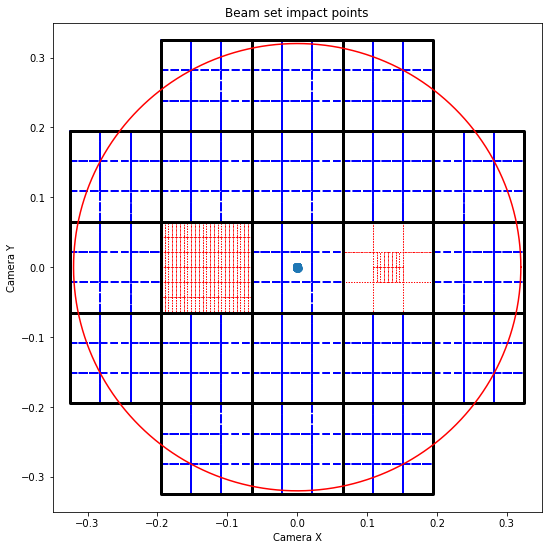

In [29]:
plotter.plot_impact_points_full_frame(impacts_r22_s11_cfg)
camera = build_camera()
show_camera(plt.gca(), camera)